In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm
import json
import os

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, ParameterGrid, KFold

from IPython.display import clear_output

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Data
## 1.1 Loading and splitting features

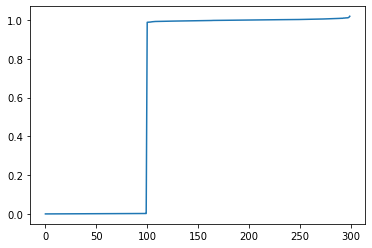

In [6]:
full_data = pd.read_csv("data/train.csv", index_col='Id')
testdata = pd.read_csv("data/test.csv", index_col='Id')

x_train_raw, y_train_raw = full_data.drop(columns=["Category"]), full_data.Category

indicies_sorted = np.argsort(x_train_raw.var())

x_train_raw = x_train_raw.to_numpy()[:, indicies_sorted]
x_test_raw = testdata.to_numpy()[:, indicies_sorted]
y_train_raw = y_train_raw.to_numpy() >= 0 # in order y to act like a distribution. DO NOT FORGET TO CHANGE IT!

plt.plot(np.var(x_train_raw, axis=0))

In [7]:
N_WHITE = 100

## 1.2 Preprocessing

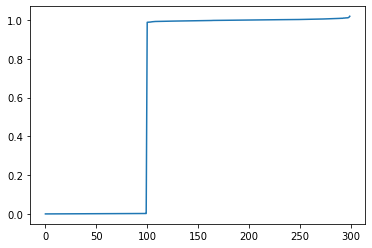

In [8]:
# scaler = StandardScaler()

# x_train = scaler.fit_transform(x_train_raw, )
# x_test = scaler.transform(x_test_raw)

x_train = x_train_raw
x_test = x_test_raw

plt.plot(np.var(x_train, axis=0))

# 2. Model side
## 2.1 Functional

In [38]:
def train_epoch(model, x_train, y_train, criterion, optimizer, batch_size=64, batches_per_epoch=10):
    model.train()
    
    loss_history = []
    train_size = x_train.shape[0]
    
    for n_batch in range(batches_per_epoch):
        
        optimizer.zero_grad()
        
        
        batch_ids = np.random.choice(train_size, batch_size)
        
        x_batch, y_batch = x_train[batch_ids], y_train[batch_ids]
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        output = model(x_batch)
        loss = criterion(output, y_batch)
        
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.data.cpu().numpy())
    
    return loss_history
             
        
def predict_proba(model, x_test, batch_size=64):
    model.eval()
    test_dataset = torch.utils.data.TensorDataset(x_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    pred = []
    
    for x_batch in test_loader:
        x_batch = x_batch[0].to(device)
        
        logits = model(x_batch) # [batch_size, 1]
        probas = torch.sigmoid(logits).data.cpu().numpy()
        
        pred.extend(probas)
        
    return np.array(pred)
    
def train_model(model, x_train, y_train, criterion, optimizer, n_epochs, batch_size, batches_per_epoch, x_val=None, y_val=None, threshold=0.5, log_best=False, name="model"):
    train_loss_history = []
    acc_history = []
    
    for epoch in range(n_epochs):
        loss = train_epoch(model, x_train, y_train, criterion, optimizer, batch_size=batch_size, batches_per_epoch=batches_per_epoch)
        train_loss_history.extend(loss)
        
        if (x_val is not None) and (y_val is not None):
            preds = predict_proba(model, x_val, batch_size=batch_size) >= threshold
            acc = np.mean(preds == y_val.numpy())
            acc_history.append(acc)
            
            
        # printing
        
#         clear_output(True)        
#         plt.subplots(1, 2, figsize=(20, 10))
        
#         plt.subplot(1, 2, 1)
#         plt.plot(train_loss_history)
    
#         plt.subplot(1, 2, 2)
#         if acc_history is not None:
#             plt.plot(acc_history)
            
            
            
            
#         print("Epoch {}: train loss={:.5f}".format(epoch, loss[-1]))
#         print("Val acc = {:.3f}, Best = {:.3f}".format(acc_history[-1], max(acc_history)))
        
#         time.sleep(0.01)
#         plt.pause(0.0001)
        
        if log_best:
            torch.save(model.state_dict(), name + "_best_val.pth")

In [18]:
def predict(model, x_test, batch_size=64, threshold=0.5):
    probas = predict_proba(model, x_test, batch_size=batch_size)
    return np.where(probas >= threshold, np.array(1), np.array(-1))

def generate_submission(model, threshold=0.5):
    X_test = torch.Tensor(x_test)
    labels = predict(model, X_test)
    
    table = pd.DataFrame(index=testdata.index)
    table['Category'] = labels
    submission_name = time.strftime("%a_%d_%H_%M",time.localtime()) + ".csv"
    
    table.to_csv("submissions/" + submission_name)

In [10]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=300, num_layers=0, 
                 hidden_dim=100, output_dim=1, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

Проведем простой тест, обучив обычный перцептрон:

In [12]:
# model = Perceptron(num_layers=4, hidden_dim=100).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# train_model(model, X_train, Y_train, torch.nn.BCEWithLogitsLoss(), optimizer, n_epochs=20, batch_size=16384, batches_per_epoch=100, x_val=X_val, y_val=Y_val)

## 2.2 Actually model

In [11]:
# Data preparation

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train_raw, test_size=0.2)

X_train = torch.Tensor(X_train)
Y_train = torch.FloatTensor(Y_train).unsqueeze(1)

X_val = torch.Tensor(X_val)
Y_val = torch.FloatTensor(Y_val).unsqueeze(1)

In [13]:
class ResBlock1D(torch.nn.Module):
    def __init__(self, hid_dim):
        super(ResBlock1D, self).__init__()
        
        self.fc_1 = torch.nn.Linear(hid_dim, hid_dim)
        self.relu_1 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(hid_dim, hid_dim)
        self.relu_2 = torch.nn.ReLU()
    
    def forward(self, in_vectors):
        hid_state = self.relu_1(self.fc_1(in_vectors))
        hid_state = self.relu_2(self.fc_2(hid_state))
        
        return hid_state + in_vectors
    
class Encoder(torch.nn.Module):
    def __init__(self, enc_name, enc_input_dim, enc_hid_dim, enc_n_layers):
        super(Encoder, self).__init__()
        assert enc_name is not None
        
        self.encoder = torch.nn.Sequential()
        
        # gate block
        self.encoder.add_module(enc_name + "_gate_linear", torch.nn.Linear(enc_input_dim, enc_hid_dim))
        self.encoder.add_module(enc_name + "_gate_bn", torch.nn.BatchNorm1d(enc_hid_dim))
        self.encoder.add_module(enc_name + "_gate_relu", torch.nn.ReLU())
        
        # tail
        for i in range(enc_n_layers):
            self.encoder.add_module(enc_name + f"_res_block_{i + 1}",
                                   ResBlock1D(enc_hid_dim))
            
    def forward(self, in_vectors):
        return self.encoder(in_vectors)
            
class Decoder(Encoder):
    def __init__(self, dec_name, dec_input_dim, dec_hid_dim, dec_n_layers):
        super(Decoder, self).__init__(dec_name, dec_input_dim, dec_hid_dim, dec_n_layers)
        
        self.classifier = torch.nn.Linear(dec_hid_dim, 1)
        
    def forward(self, in_vectors):
        hid_state = self.encoder(in_vectors)
        
        return self.classifier(hid_state)

In [14]:
dec = Decoder("my_dec", 100, 50, 3)
dec

Decoder(
  (encoder): Sequential(
    (my_dec_gate_linear): Linear(in_features=100, out_features=50, bias=True)
    (my_dec_gate_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (my_dec_gate_relu): ReLU()
    (my_dec_res_block_1): ResBlock1D(
      (fc_1): Linear(in_features=50, out_features=50, bias=True)
      (relu_1): ReLU()
      (fc_2): Linear(in_features=50, out_features=50, bias=True)
      (relu_2): ReLU()
    )
    (my_dec_res_block_2): ResBlock1D(
      (fc_1): Linear(in_features=50, out_features=50, bias=True)
      (relu_1): ReLU()
      (fc_2): Linear(in_features=50, out_features=50, bias=True)
      (relu_2): ReLU()
    )
    (my_dec_res_block_3): ResBlock1D(
      (fc_1): Linear(in_features=50, out_features=50, bias=True)
      (relu_1): ReLU()
      (fc_2): Linear(in_features=50, out_features=50, bias=True)
      (relu_2): ReLU()
    )
  )
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)

In [15]:
dec(torch.randn(53, 100)).shape

torch.Size([53, 1])

In [16]:
class BlackWhiteNet(torch.nn.Module):
    def __init__(self, white_input_dim, white_hid_dim, white_n_layers,  black_input_dim, black_hid_dim, black_n_layers, dec_hid_dim, dec_n_layers):
        super(BlackWhiteNet, self).__init__()
        
        self.white_encoder = Encoder("white_encoder", white_input_dim, white_hid_dim, white_n_layers)
        self.black_encoder = Encoder("black_encoder", black_input_dim, black_hid_dim, black_n_layers)
        
        self.decoder = Decoder("decoder", white_hid_dim + black_hid_dim, dec_hid_dim, dec_n_layers)
        
    def forward(self, in_features):
        white_features = in_features[:, :N_WHITE]
        black_features = in_features[:, N_WHITE:]
        
        white_hid_state = self.white_encoder(white_features)
        black_hid_state = self.black_encoder(black_features)
        
        hid_state = torch.cat((white_hid_state, black_hid_state), dim=1)
        
        return self.decoder(hid_state)

In [ ]:
params = {
    "white_input_dim": 100,
    "white_hid_dim": 20,
    "white_n_layers": 3,
    "black_input_dim": 200,
    "black_hid_dim": 12,
    "black_n_layers": 4,
    "dec_hid_dim": 30,
    "dec_n_layers": 2
}

baseline = BlackWhiteNet(**params).to(device)
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-4)

In [ ]:
pytorch_total_params = sum(p.numel() for p in baseline.parameters() if p.requires_grad)
pytorch_total_params

In [ ]:
train_model(baseline,
            X_train, Y_train,
            torch.nn.BCEWithLogitsLoss(), optimizer,
            n_epochs=100, batch_size=16384, batches_per_epoch=100,
            x_val=X_val, y_val=Y_val, 
            log_best=True, name="baseline")

In [ ]:
torch.save(baseline.state_dict(), "models/baseline_100.pth")

## 2.3 Generate first submission

In [ ]:
# baseline.load_state_dict(torch.load("models/baseline_best_val"))
# generate_submission(baseline)

## 2.4 Grid Search

In [51]:
nn_grid = ParameterGrid({
    "white_hid_dim": [20],
    "white_n_layers": [3],
    "black_hid_dim": [12, 15],
    "black_n_layers": [4],
    "dec_hid_dim": [30],
    "dec_n_layers": [2]
})

In [52]:
kfold = KFold(2, shuffle=True)

cv_path = "models/cv/"
os.makedirs(cv_path, exist_ok=True)

with open(cv_path + "cv_grid.json", "w") as f:
    id_to_item_dict = {}   
    for item_id, item in enumerate(nn_grid):
        id_to_item_dict[item_id] = item
        
    json.dump(id_to_item_dict, f, indent=2)

    
scores = {}

for item_id, item in tqdm(enumerate(nn_grid)):
    acc_values = []
    for n_fold, (train_ids, val_ids) in enumerate(kfold.split(x_train)):
        # train/val split
        X_train = torch.Tensor(x_train[train_ids])
        Y_train = torch.FloatTensor(y_train_raw[train_ids]).unsqueeze(1)
        
        X_val = torch.Tensor(x_train[val_ids])
        Y_val = torch.FloatTensor(y_train_raw[val_ids]).unsqueeze(1)
        
        # model side
        model = BlackWhiteNet(**item, white_input_dim=100, black_input_dim=200).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        
        # path where to save best model
        os.makedirs(cv_path + f"item_no_{item_id}", exist_ok=True)
        path = cv_path + f"item_no_{item_id}/fold_{n_fold}"
        
        
        # train model
        train_model(model, 
                    X_train, Y_train,
                    torch.nn.BCEWithLogitsLoss(), optimizer,
                    n_epochs=2, batch_size=16384, batches_per_epoch=100,
                    x_val=X_val, y_val=Y_val, log_best=True, name=path)
        
        
        # evaluating
        
        # load best model
        model.load_state_dict(torch.load(path + "_best_val.pth"))
        
        # predict
        probas = predict_proba(model, X_val)
        acc = accuracy_score(Y_val, probas > 0.5)
        
        acc_values.append(acc)
    
    # write results to dict
    scores[item_id] = "{:.3f} +/- {:.3f}".format(np.mean(acc_values), np.std(acc_values))
    
    # dump results to file
    with open(cv_path + "scores.json", "w") as f:
        json.dump(scores, f)

## 3. Implementing stacking

In [13]:
X_train_white = X_train[:, :N_WHITE]
X_train_black = X_train[:, N_WHITE:]

X_val_white = X_val[:, :N_WHITE]
X_val_black = X_val[:, N_WHITE:]

X_train_white.shape, X_train_black.shape

(torch.Size([72000, 100]), torch.Size([72000, 200]))

Epoch 13: train loss=0.34743
Val acc = 0.752, Best = 0.754


KeyboardInterrupt: 

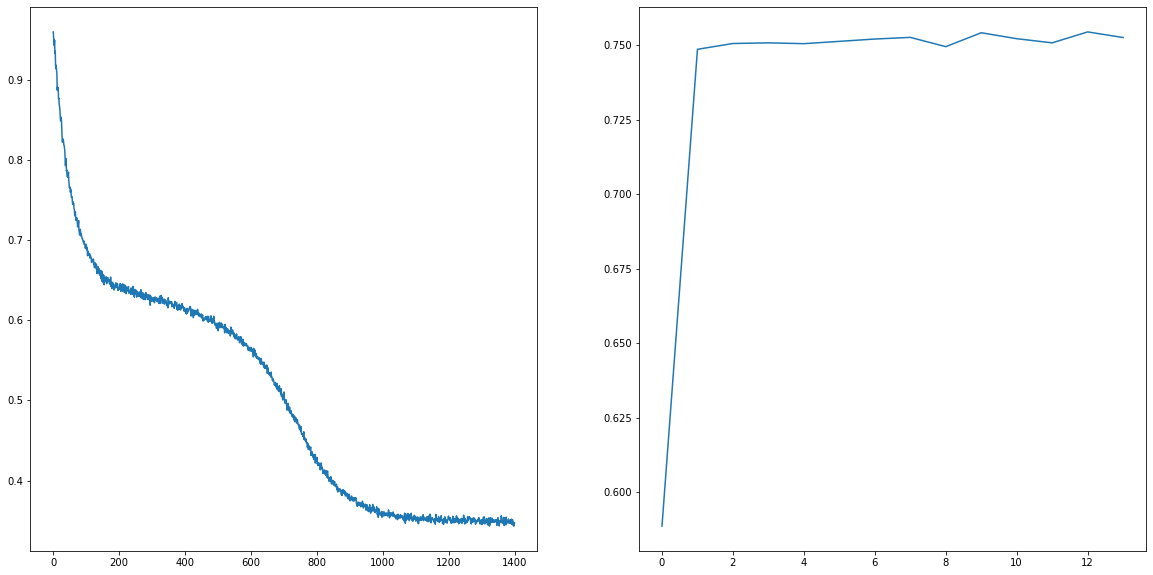

In [57]:
white_net = Decoder("white_net", 100, 20, 7).to(device)
white_optim = torch.optim.Adam(white_net.parameters(), lr=1e-4)

train_model(white_net,
            X_train_white, Y_train,
            torch.nn.BCEWithLogitsLoss(), optimizer=white_optim,
            n_epochs=100, batch_size=16384, batches_per_epoch=100,
            x_val=X_val_white, y_val=Y_val)

Epoch 21: train loss=0.55290
Val acc = 0.701, Best = 0.702


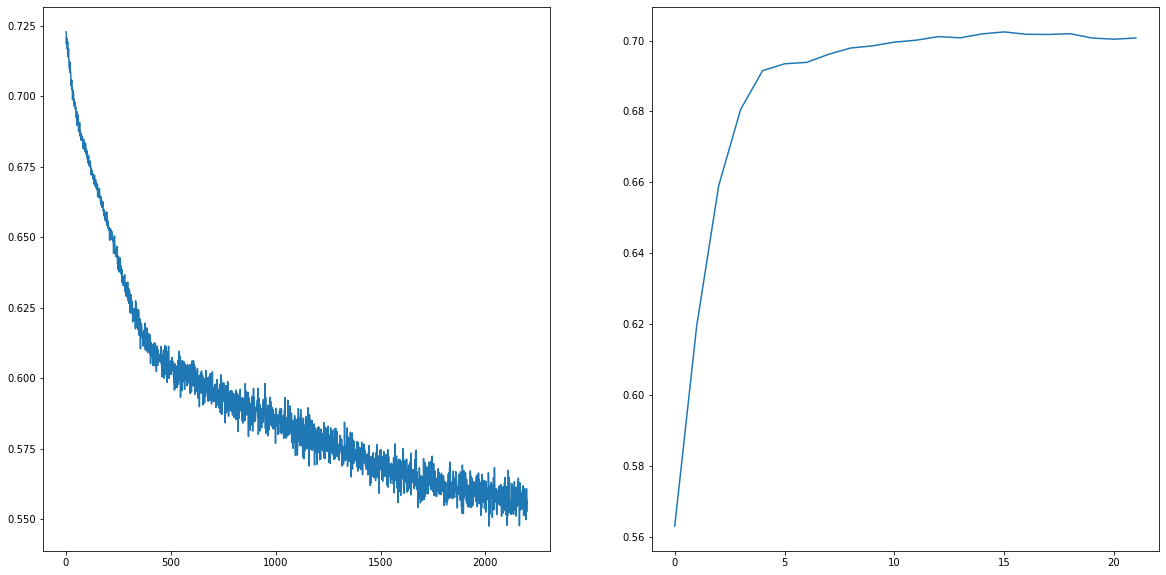

KeyboardInterrupt: 

In [21]:
black_net = Decoder("black_net", 200, 15, 5).to(device)
black_optim = torch.optim.Adam(black_net.parameters(), lr=1e-4)

train_model(black_net,
            X_train_black, Y_train,
            torch.nn.BCEWithLogitsLoss(), optimizer=black_optim,
            n_epochs=100, batch_size=16384, batches_per_epoch=100,
            x_val=X_val_black, y_val=Y_val)

In [23]:
white_probas_train = predict_proba(white_net, X_train_white)
black_probas_train = predict_proba(black_net, X_train_black)

white_probas_val = predict_proba(white_net, X_val_white)
black_probas_val = predict_proba(black_net, X_val_black)

In [29]:
y_train = Y_train.numpy()
y_val = Y_val.numpy()


probas_train = np.hstack((white_probas_train, black_probas_train))
probas_val = np.hstack((white_probas_val, black_probas_val))

probas_train.shape,probas_val.shape

((72000, 2), (18000, 2))

In [27]:
from xgboost import XGBClassifier


space = {
    'n_estimators' : 100, # Done
    'eta' : 0.1,
    'max_depth': 3, # Done
}

blender = XGBClassifier(**space)
blender.fit(probas_train, y_train)

/home/serg/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/serg/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[17:26:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
from sklearn.metrics import classification_report

print(accuracy_score(y_val, blender.predict(probas_val)))

NameError: name 'y_val' is not defined

Score is about 0.91, so it is not good enough.